In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import drive
import matplotlib
import seaborn as sns

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#If you have it on drive
drive.mount('/content/drive')
df = pd.read_csv("drive/MyDrive/IMDB_Dataset.csv")

Mounted at /content/drive


In [ ]:
#If you have it loaded in this notebook
#Need to wait until dataset is completely loaded otherwise it will throw an error
df = pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isnull().any()

review       False
sentiment    False
dtype: bool

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


There are duplicated values

In [ ]:
duplicates = df[df['review'].isin(df['review'][df['review'].duplicated()])].sort_values("review")
duplicates

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative
...,...,...
47876,this movie sucks. did anyone notice that the e...,negative
44122,"well, the writing was very sloppy, the directi...",negative
23056,"well, the writing was very sloppy, the directi...",negative
10163,"when I first heard about this movie, I noticed...",positive


In [ ]:
duplicates.groupby('review').filter(lambda x: x['sentiment'].nunique() > 1)

,review,sentiment


All duplicated reviews have the same sentiment, we can remove them

In [ ]:
df = df.drop_duplicates(subset=['review'], keep='first')

In [ ]:
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [ ]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

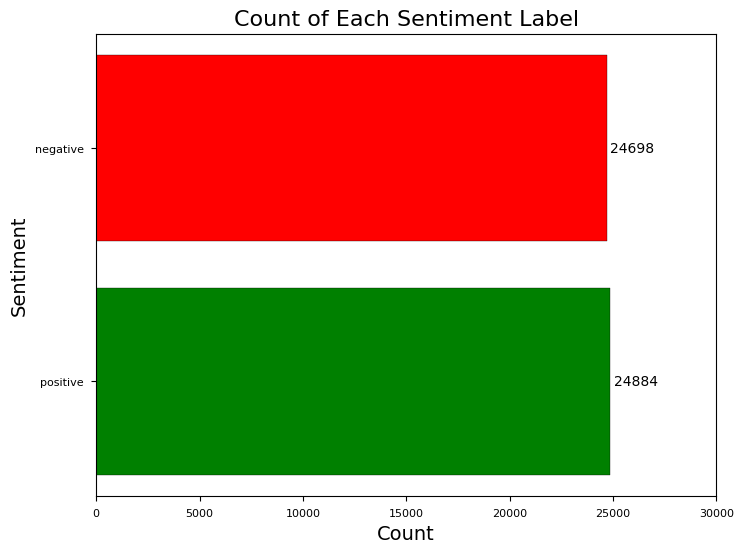

In [ ]:
#this plot is quite useless actually

sentiment_counts = df['sentiment'].value_counts()

plt.style.use('seaborn-v0_8-paper')

plt.figure(figsize=(8, 6))
bars = plt.barh(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'], edgecolor='black')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.xlim(0, 30000)
plt.title('Count of Each Sentiment Label', fontsize=16)

for bar in bars:
    plt.text(bar.get_width() + 150, bar.get_y() + bar.get_height() / 2, str(bar.get_width()),
             ha='left', va='center')

# Displaying the plot
plt.show()

In [ ]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [ ]:
df['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

The reviews contain special characters and html tags, we can handle this later

Encode sentiment as either 1 or 0

In [ ]:
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


In [ ]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df

,review,sentiment,label,review_length
0,One of the other reviewers has mentioned that ...,positive,1,307
1,A wonderful little production. <br /><br />The...,positive,1,162
2,I thought this was a wonderful way to spend ti...,positive,1,166
3,Basically there's a family where a little boy ...,negative,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,194
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,112
49997,I am a Catholic taught in parochial elementary...,negative,0,230
49998,I'm going to have to disagree with the previou...,negative,0,212


Plot the distribution of review length. I think it is too big to fit on the two column screen so likely we will need to split it (later).

<Axes: title={'center': 'Word Count Distribution in Negative Reviews'}, xlabel='Review Word Count', ylabel='Frequency'>

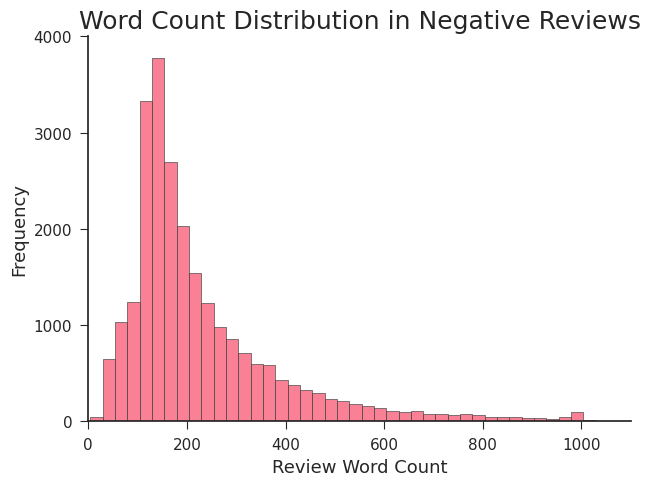

In [ ]:
sns.set_theme(style="ticks")
sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-paper')


binwidth = 25

min = np.min(df['review_length'])
max = np.max(df['review_length'])


#matplotlib.rcParams['font.family'] = ['Roboto'] #This works locally but its a better font

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
plt.title('Word Count Distribution in Negative Reviews', fontsize=18)
plt.xlabel('Review Word Count', fontsize=13)
plt.xticks(np.arange(0, 1500, 200), fontsize=11)
plt.xlim(0, 1100)
plt.ylabel('Frequency', fontsize=13)
plt.yticks(np.arange(0, 14000, 1000), fontsize=11)
plt.ylim(0, 4000)
sns.histplot(
    df[df['sentiment'] == 'negative'],
    x="review_length",
    alpha=0.5,
    color='#f7022e',
    edgecolor=".3",
    linewidth=.5,
    bins=range(min, max + binwidth, binwidth))

In [ ]:
min, max

(4, 2470)

<Axes: title={'center': 'Word Count Distribution in Positive Reviews'}, xlabel='Review Word Count', ylabel='Frequency'>

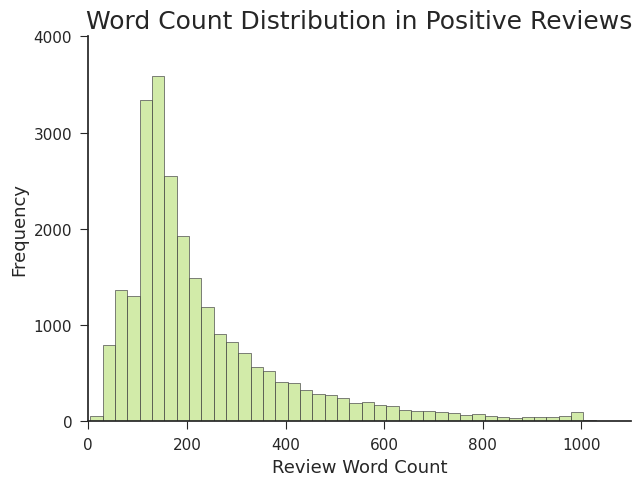

In [ ]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
plt.title('Word Count Distribution in Positive Reviews', fontsize=18)
plt.xlabel('Review Word Count', fontsize=13)
plt.xticks(np.arange(0, 1500, 200), fontsize=11)
plt.xlim(0, 1100)
plt.ylabel('Frequency', fontsize=13)
plt.yticks(np.arange(0, 14000, 1000), fontsize=11)
plt.ylim(0, 4000)
sns.histplot(
    df[df['sentiment'] == 'positive'],
    x="review_length",
    alpha=0.5,
    color='#a6d854',
    edgecolor=".3",
    linewidth=.5,
    bins=range(min, max + binwidth, binwidth))

In [ ]:
from scipy import stats
#Not normal but CLT works well with 25k samples
t_stat, p_value = stats.ttest_ind(df[df['sentiment'] == 'positive']['review_length'], df[df['sentiment'] == 'negative']['review_length'])

In [ ]:
p_value

0.023346823855078545

In [ ]:
df[df['sentiment'] == 'positive']['review_length'].mean()

233.09062047902268

In [ ]:
df[df['sentiment'] == 'positive']['review_length'].median()

172.0

In [ ]:
df[df['sentiment'] == 'negative']['review_length'].mean()

229.59660701271358

In [ ]:
df[df['sentiment'] == 'negative']['review_length'].median()

174.0

The most common words are redundant, perhaps better to do after lemmatization and stop word removal

In [ ]:
all_words = df['review'].apply(lambda x: x.lower()).apply(lambda x: x.split()).to_numpy()
all_words = [word for sublist in all_words for word in sublist]
word_counts = Counter(all_words)
word_counts.most_common(10)

[('the', 633981),
 ('a', 314408),
 ('and', 311378),
 ('of', 284608),
 ('to', 262599),
 ('is', 203488),
 ('in', 178487),
 ('i', 140393),
 ('this', 137398),
 ('that', 129179)]

In [ ]:
all_positive_words = df[df['sentiment'] == 'positive']['review'].apply(lambda x: x.lower()).apply(lambda x: x.split()).to_numpy()
all_positive_words = [word for sublist in all_positive_words for word in sublist]
word_counts = Counter(all_positive_words)
word_counts.most_common(10)

[('the', 325111),
 ('and', 170782),
 ('a', 160440),
 ('of', 150236),
 ('to', 129177),
 ('is', 108654),
 ('in', 95343),
 ('i', 66516),
 ('it', 64530),
 ('this', 63902)]

In [ ]:
all_negative_words = df[df['sentiment'] == 'negative']['review'].apply(lambda x: x.lower()).apply(lambda x: x.split()).to_numpy()
all_negative_words = [word for sublist in all_negative_words for word in sublist]
word_counts = Counter(all_negative_words)
word_counts.most_common(10)

[('the', 308870),
 ('a', 153968),
 ('and', 140596),
 ('of', 134372),
 ('to', 133422),
 ('is', 94834),
 ('in', 83144),
 ('i', 73877),
 ('this', 73496),
 ('that', 65536)]

In [ ]:
#I took a lot of those from websites

def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text

def remove_html(text):
    return re.sub(r'<[^>]+>', '', text)

def remove_number(text):
    return re.sub(r'\d+', '', text)

def convert_to_lowercase(text):
    lowercased_text = text.lower()
    return lowercased_text

def remove_whitespaces(text):
    return re.sub(r' +', ' ', text)

def clean_pipeline(text):
    no_html = remove_html(text)
    #spelling = correct_spelling(fix_spaces) <- this is good but suuuuper slow
    no_numbers = remove_number(no_html)
    lower_case = convert_to_lowercase(no_numbers)
    no_whitespaces = remove_whitespaces(lower_case)
    return no_whitespaces

In [ ]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
clean_pipeline(df['review'][0])

"one of the other reviewers has mentioned that after watching just oz episode you'll be hooked . they are right , as this is exactly what happened with me . the first thing that struck me about oz was its brutality and unflinching scenes of violence , which set in right from the word go . trust me , this is not a show for the faint hearted or timid . this show pulls no punches with regards to drugs , sex or violence . its is hardcore , in the classic use of the word . it is called oz as that is the nickname given to the oswald maximum security state penitentary . it focuses mainly on emerald city , an experimental section of the prison where all the cells have glass fronts and face inwards , so privacy is not high on the agenda . em city is home to many . . aryans , muslims , gangstas , latinos , christians , italians , irish and more . . . . so scuffles , death stares , dodgy dealings and shady agreements are never far away . i would say the main appeal of the show is due to the fact 

In [ ]:
clean_pipeline(df['review'][2000])

"stranded in space () mstk version - a very not good tv movie pilot , for a never to be made series , in which an astronaut finds himself trapped on earth's evil twin . having a planet of identical size and mass orbiting in the same plane as the earth , but on the opposite side of the sun , is a well worn sf chestnut - the idea is over , years old , having been invented by the ancient greeks . in this version the counter world is run as an orwellian 'perfect' society . where , for totally inexplicable reasons , everyone speaks english and drives late model american cars . after escaping from his prisonlike hospital , the disruptive earthian is chased around not southern california by tv and bad movie stalwart cameron mitchell who , like his minions , wears double breasted suits and black polo neck jumpers - a stylishly evil combination which i fully intend to adopt if ever i become a totalitarian overlord . our hero escapes several times before ending up gazing at the alien world's thr

In [ ]:
df['clean'] = df['review'].apply(clean_pipeline)

  0%|          | 0/49582 [00:00<?, ?it/s]

In [ ]:
df

,review,sentiment,label,review_length,clean
0,One of the other reviewers has mentioned that ...,positive,1,1761,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,998,a wonderful little production . the filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,926,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,748,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,1317,"petter mattei's ""love in the time of money"" is..."
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,1008,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,642,"bad plot , bad dialogue , bad acting , idiotic..."
49997,I am a Catholic taught in parochial elementary...,negative,0,1280,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,0,1234,i'm going to have to disagree with the previou...


In [ ]:
#def tokenize(text):
#    return word_tokenize(text)

#def remove_stopwords(text):
#    stop_words = set(stopwords.words('english'))
#    return [i for i in text if i not in stop_words]

#def lemmatize(text):
#    lemmatizer = WordNetLemmatizer()
#    lemmas = [lemmatizer.lemmatize(t) for t in text]
#    return remove_stopwords(lemmas)

#def preprocess_pipeline(text):
#    tokens = tokenize(text)
#    no_stopwords = remove_stopwords(tokens)
#    lemmas = lemmatize(no_stopwords)
#    return ' '.join(lemmas)


def remove_punctuation(data):
    return [token for token in data if not token.is_punct]

def remove_stopwords(data):
    return [token for token in data if not token.is_stop]

def lemmatize(data):
    return [token.lemma_ for token in data]

def verify(data):
  return [token for token in data if len(token) > 1]

nlp = spacy.load('en_core_web_sm')
#contextualSpellCheck.add_to_pipe(nlp)

def spacy_pipeline(data):
    data = nlp(data)
    removed_punctuation = remove_punctuation(data) # Remove punctuation
    removed_stopwords = remove_stopwords(removed_punctuation)  # Remove stopwords
    lemmatized = lemmatize(removed_stopwords) # Lemmatize
    verified = verify(lemmatized) #Artefact removal
    return ' '.join([token for token in verified])


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
df['processed'] = df['clean'].progress_apply(spacy_pipeline)

  0%|          | 0/49582 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
spacy_pipeline(df['processed'][4])

KeyError: 'processed'

In [ ]:
df['clean'][4]

In [ ]:
df['processed'][0]

In [ ]:
df[['processed', 'label']].to_csv('./imdb_dataset_processed.csv', index=False, header=True)

In [ ]:
all_words = df['processed'].progress_apply(lambda x: x.lower()).progress_apply(lambda x: x.split()).to_numpy()
all_words = [word for sublist in all_words for word in sublist]
word_counts = Counter(all_words)
word_counts.most_common(50)

In [ ]:
all_positive_words = df[df['sentiment'] == 'positive']['processed'].progress_apply(lambda x: x.lower()).progress_apply(lambda x: x.split()).to_numpy()
all_positive_words = [word for sublist in all_positive_words for word in sublist]
word_counts = Counter(all_positive_words)
word_counts.most_common(50)

In [ ]:
all_positive_words = df[df['sentiment'] == 'negative']['processed'].progress_apply(lambda x: x.lower()).progress_apply(lambda x: x.split()).to_numpy()
all_positive_words = [word for sublist in all_positive_words for word in sublist]
word_counts = Counter(all_positive_words)
word_counts.most_common(50)

In [ ]:
# load from file
df_processed = pd.read_csv("imdb_dataset_processed_new.csv")


In [ ]:
df_processed

,processed,label
0,reviewer mention watch oz episode hook right e...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49577,think movie right good job creative original e...,1
49578,bad plot bad dialogue bad acting idiotic direc...,0
49579,catholic teach parochial elementary school nun...,0
49580,go disagree previous comment maltin second rat...,0


from matplotlib import pyplot as plt
df_processed['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_processed['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from gensim.models import Word2Vec

all_words = [line.split() for line in df_processed['processed']]
print(all_words[0:10])

#min count - min number of word repetitions to consider a word
#workers - nr of parallel cores to train
#vector size - nr of values to represent a word (around 150-300)
#window - window size used to predict meaning
w2v = Word2Vec(all_words, vector_size=200, window=5, workers=4, epochs=5, min_count=1)
#train ???


[['reviewer', 'mention', 'watch', 'oz', 'episode', 'hook', 'right', 'exactly', 'happen', 'thing', 'strike', 'oz', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'faint', 'hearted', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'call', 'oz', 'nickname', 'give', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'aryan', 'muslims', 'gangsta', 'latinos', 'christians', 'italians', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'far', 'away', 'main', 'appeal', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romance', 'oz', 'mess', 'episode', 'see', 'strike', 'nasty', 'surreal', 'ready', 'watch', 'develop', 'taste', 'oz', '

In [ ]:
words = list(w2v.wv.key_to_index.keys())

In [ ]:
print(words[100:110])

['seems', 'young', 'action', 'big', 'however', 'enough', 'right', 'long', 'line', 'ive']


In [ ]:
#check for similiraties
print(w2v.wv.most_similar('action', topn = 3))
print(w2v.wv.most_similar('movie', topn = 3))
print(w2v.wv.most_similar('actor', topn = 3))
print(w2v.wv.most_similar('spectacular', topn = 3))
print(w2v.wv.most_similar('awful', topn = 3))
#classical example
result_vector = w2v.wv['actor'] - w2v.wv['man'] + w2v.wv['woman']
similar_words = w2v.wv.similar_by_vector(result_vector, topn=3)
print(similar_words)

print( w2v.wv['action'] )



[('fighting', 0.5968160033226013), ('suspense', 0.5289818048477173), ('excitement', 0.5175337195396423)]
[('film', 0.7432858347892761), ('honestly', 0.6466222405433655), ('probably', 0.6175671219825745)]
[('actress', 0.6735142469406128), ('performer', 0.6045143008232117), ('casting', 0.552931010723114)]
[('impressive', 0.8347950577735901), ('breathtaking', 0.8166378736495972), ('breathtake', 0.7885564565658569)]
[('terrible', 0.8496319055557251), ('dreadful', 0.8375676274299622), ('horrible', 0.8368040323257446)]
[('actor', 0.7409998178482056), ('actress', 0.6941869854927063), ('performer', 0.4840376377105713)]
[ 0.8855394   0.6356103  -3.1825066  -0.3249463  -1.5318675   0.2745037
  1.2415785   0.723942   -0.00467614 -0.97402734  0.10067524  1.1161357
  0.39882562 -0.10973954 -1.3438538  -0.08924218  2.4664757  -0.78441316
 -0.5722609  -0.33859104  1.43969     1.7396754  -0.01309484  2.468183
 -0.11808559 -0.2336776   0.06910854  1.1342944   2.1223834  -1.3480465
  1.8803687   0.87728

In [ ]:
def encode_and_pad_review(review, model, max_length = 1200, embed_dim = 200):
    # Initialize an empty list to store word vectors
    review_vectors = []
    for word in review:
        # Check if the word is in the vocabulary
        if word in model.wv.key_to_index:
            # Retrieve the word vector and append it to the list, otherwise do not consider
            review_vectors.append(model.wv[word])
    if review_vectors:
        if len(review_vectors) > max_length:
            review_vectors = review_vectors[:max_length]
        else:
            review_vectors += [np.zeros(embed_dim) for _ in range(max_length - len(review_vectors))]
        return review_vectors
    else:
        return []

# Apply the function to each review and create a list of tuples containing encoded reviews and labels
encoded_reviews = []
for index, row in df_processed.iterrows():
    review = row['processed'].split()  # Split the processed review into words
    encoded_review_vector = encode_and_pad_review(review, w2v)
    if encoded_review_vector is not None:
        encoded_reviews.append((encoded_review_vector, row['label']))

# Convert the list of tuples to a DataFrame
encoded_df = pd.DataFrame(encoded_reviews, columns=['review_vector', 'label'])

NameError: name 'df_processed' is not defined

In [ ]:
encoded_df

,review_vector,label
0,"[[-0.3621156, 0.233422, -1.9956231, 0.8250672,...",1
1,"[[-1.14956, 0.790235, -0.26978245, -0.58196795...",1
2,"[[0.20934018, 0.040833753, -1.0370474, 1.28360...",1
3,"[[0.21495025, -1.082975, -1.0491457, -0.003707...",0
4,"[[0.00866043, -0.001660284, 0.0030023113, -0.0...",1
...,...,...
49577,"[[0.20934018, 0.040833753, -1.0370474, 1.28360...",1
49578,"[[-0.16717638, -0.9357709, -0.9094029, -0.0689...",0
49579,"[[0.7368588, -0.3165298, -0.13853218, 0.004550...",0
49580,"[[1.82207, 1.1510106, -0.66707164, -1.3883888,...",0


In [ ]:
print(len(encoded_df['review_vector'][1]))
print(len(df_processed['processed'][1].split()))

86
86


In [ ]:
# Function to convert vector representation back to words
def vector_to_words(encoded_vector, model, top_n=1):
    # Find the most similar words to each component of the encoded vector
    similar_words = []
    # Loop might be unnecessary, no time to fix now
    for vector_component in encoded_vector:
        word = model.wv.similar_by_vector(vector_component, topn=top_n)[0][0]
        similar_words.append(word)
    return similar_words

# Example usage:
encoded_vector = encoded_df['review_vector'][0]
nearest_words = vector_to_words(encoded_vector, w2v)
print(nearest_words)
print(df_processed['processed'][0].split())


['one', 'reviewer', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'wouldnt', 'dare', 'forget', 'pretty', 'picture', 'painted', 'mainstream', 'audience', 'forget', 'charm', 'forget', 

In [ ]:

print("Shortest review: ", min(len(review.split()) for review in df_processed['processed']))
print("Average review: ", sum(len(review.split()) for review in df_processed['processed'])/len(df_processed))
print("Longest review: ", max(len(review.split()) for review in df_processed['processed']))
# use the tutorial from link 5

df_processed['review_length'] = df_processed['processed'].apply(lambda x: len(x.split()))



Shortest review:  3
Average review:  102.48685006655641
Longest review:  1268


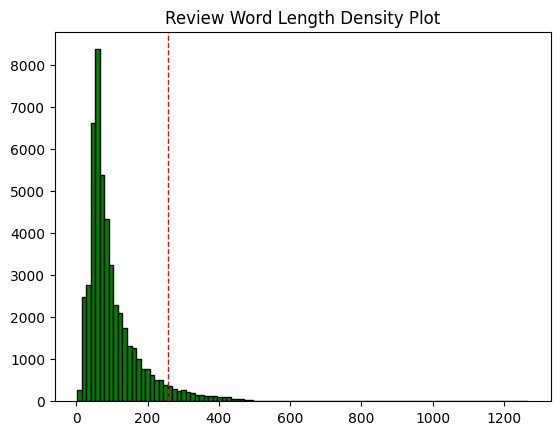

In [ ]:
plt.hist(df_processed['review_length'], bins=100, color='green', edgecolor='black')
plt.title('Review Word Length Density Plot')
plt.axvline(x=256, color='red', linestyle='--', linewidth=1, label='Trimmed size')

In [ ]:
reviews_over_the_length_limit = 0
for length in df_processed['review_length']:
  if length > 256:
    reviews_over_the_length_limit += 1
print("Number of reviews exceeding the length limit:", reviews_over_the_length_limit)
print("Percentage of reviews exceeding the length limit:",reviews_over_the_length_limit/len(df_processed))

Number of reviews exceeding the length limit: 2811
Percentage of reviews exceeding the length limit: 0.05669396151829293
